<a href="https://colab.research.google.com/github/SeWonKwon/NLP/blob/main/L010_Keras_Word2Vec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 케라스 Word2Vec 구현

* 참고: https://wikidocs.net/69141

### 전처리

In [9]:
from sklearn.datasets import fetch_20newsgroups

dataset = fetch_20newsgroups(shuffle=True, random_state=1,
                             remove=('headers', 'footers', 'quotes'))

documents = dataset.data

print(len(documents))
documents[1]

11314


"\n\n\n\n\n\n\nYeah, do you expect people to read the FAQ, etc. and actually accept hard\natheism?  No, you need a little leap of faith, Jimmy.  Your logic runs out\nof steam!\n\n\n\n\n\n\n\nJim,\n\nSorry I can't pity you, Jim.  And I'm sorry that you have these feelings of\ndenial about the faith you need to get by.  Oh well, just pretend that it will\nall end happily ever after anyway.  Maybe if you start a new newsgroup,\nalt.atheist.hard, you won't be bummin' so much?\n\n\n\n\n\n\nBye-Bye, Big Jim.  Don't forget your Flintstone's Chewables!  :) \n--\nBake Timmons, III"

In [14]:
import re
import nltk

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.download('stopwords')
nltk.download('punkt')

def clean_text(d):
  pattern = r'[^a-zA-Z\s]'
  text = re.sub(pattern, '', d)
  return text

def clean_stopword(d):
  stop_words = stopwords.words('english')
  return ' '.join([w.lower() for w in d.split() if w.lower() not in stop_words and len(w) > 3])

def tokenize(d):
  return word_tokenize(d)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [11]:
import pandas as pd

news_df = pd.DataFrame({'article': documents})
len(news_df)

11314

In [12]:
news_df.replace("", float("NaN"), inplace=True)
news_df.dropna(inplace=True)
print(len(news_df))

11096


In [15]:
news_df['article'] = news_df['article'].apply(clean_text)
news_df['article']

0        Well im not sure about the story nad it did se...
1        \n\n\n\n\n\n\nYeah do you expect people to rea...
2        Although I realize that principle is not one o...
3        Notwithstanding all the legitimate fuss about ...
4        Well I will have to change the scoring on my p...
                               ...                        
11309    Danny Rubenstein an Israeli journalist will be...
11310                                                   \n
11311    \nI agree  Home runs off Clemens are always me...
11312    I used HP DeskJet with Orange Micros Grappler ...
11313                                          \nNo arg...
Name: article, Length: 11096, dtype: object

In [17]:
news_df['article'] = news_df['article'].apply(clean_stopword)
news_df['article']

0        well sure story seem biased disagree statement...
1        yeah expect people read actually accept hard a...
2        although realize principle strongest points wo...
3        notwithstanding legitimate fuss proposal much ...
4        well change scoring playoff pool unfortunately...
                               ...                        
11309    danny rubenstein israeli journalist speaking t...
11310                                                     
11311    agree home runs clemens always memorable kinda...
11312    used deskjet orange micros grappler system upd...
11313    argument murphy scared hell came last year han...
Name: article, Length: 11096, dtype: object

In [20]:
tokenized_news = news_df['article'].apply(tokenize)
tokenized_news = tokenized_news.to_list()
print(len(tokenized_news))

11096


In [21]:
import numpy as np
drop_news = [index for index, sentence in enumerate(tokenized_news) if len(sentence) <= 1]
news_text = np.delete(tokenized_news, drop_news, axis=0)
print(len(news_text))

10939


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [23]:
from tensorflow.keras.preprocessing.text import Tokenizer

news_2000 = news_text[:2000]

tokenizer = Tokenizer()

tokenizer.fit_on_texts(news_2000)

# 키와 밸류를 인버스 시켜준다. 
idx2word = {value:key for key, value in tokenizer.word_index.items()}
sequences = tokenizer.texts_to_sequences(news_2000)

In [24]:
vocab_size = len(tokenizer.word_index)+1
print(vocab_size)

29706


In [25]:
print(sequences[1])

[1232, 443, 2, 56, 113, 405, 57, 1342, 20, 65, 3454, 384, 6822, 1142, 360, 2217, 444, 55, 12419, 444, 1862, 3804, 384, 20, 9, 4279, 8694, 171, 291, 130, 148, 648, 12420, 304, 12421, 14, 12422, 4, 770, 12423, 12424, 4870, 8695]


### Skipgram

#### Skipgram 전처리

* 네거티브 샘플링(Negative Sampling)

  + Word2Vec은 출력층이 내놓는 값에 소프트맥스 함수를 적용해 확률값으로 변환한 후 이를 정답과 비교해 역전파(backpropagation)
  + 소프트맥스를 적용하려면 분모에 해당하는 값, 즉 중심단어와 나머지 모든 단어의 내적을 한 뒤, 이를 다시 exp 계산을 하는데 전체 단어가 많을 경우 엄청난 계산량 발생
  + 네거티브 샘플링은 소프트맥스 확률을 구할 때 전체 단어를 대상으로 구하지 않고, **일부 단어만 뽑아서 계산을 하는 방식**
  + 네거티브 샘플링 동작은 사용자가 지정한 윈도우 사이즈 내에 등장하지 않는 단어(negative sample)를 5~20개 정도 뽑고, 이를 정답단어와 합쳐 전체 단어처럼 소프트맥스 확률을 계산하여 파라미터 업데이트

In [26]:
from tensorflow.keras.preprocessing.sequence import skipgrams

skip_grams = [skipgrams(sample, vocabulary_size=vocab_size, window_size=10) for sample in sequences[:10]]

In [30]:
pairs, labels = skip_grams[0][0], skip_grams[0][1]
for i in range(5):
  print("{:s}({:d}), {:s}({:d}) -> {:d}".format(
      idx2word[pairs[i][0]], pairs[i][0],
      idx2word[pairs[i][1]], pairs[i][1],
      labels[i] ))

proisraeli(12417), sane(13651) -> 0
whole(195), telecast(5649) -> 0
clearly(564), becomming(27419) -> 0
europeans(3453), substituted(13023) -> 0
received(374), austria(4278) -> 1


In [31]:
print(len(skip_grams))
print(len(pairs))
print(len(labels))

10
2220
2220


In [32]:
skip_grams = [skipgrams(seq, vocabulary_size=vocab_size, window_size=10) for seq in sequences]

#### Skipgram 모델 구성

In [33]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, Reshape, Activation, Input, Dot
from tensorflow.keras.utils import plot_model

In [34]:
embed_size = 50


In [37]:
def word2vec():
  target_inputs = Input(shape=(1, ), dtype='int32')
  target_embedding = Embedding(vocab_size, embed_size)(target_inputs)

  context_inputs = Input(shape=(1, ), dtype='int32')
  context_embedding = Embedding(vocab_size, embed_size)(context_inputs)

  dot_product = Dot(axes=2)([target_embedding, context_embedding])
  dot_product = Reshape((1, ), input_shape=(1, 1))(dot_product)
  outputs = Activation('sigmoid')(dot_product)

  model = Model(inputs=[target_inputs, context_inputs], outputs=outputs)
  model.compile(loss='binary_crossentropy', optimizer='adam')

  return model

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 50)        1485300     input_2[0][0]                    
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 1, 50)        1485300     input_3[0][0]                    
______________________________________________________________________________________________

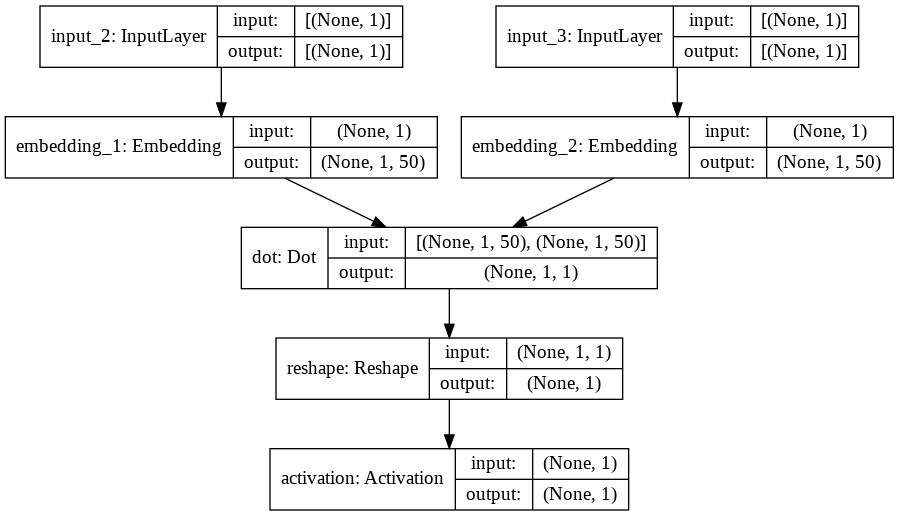

In [38]:
model = word2vec()
model.summary()
plot_model(model, show_shapes=True, show_layer_names=True)

In [40]:
for epoch in range(1, 11):
  loss = 0
  for _, elem in enumerate(skip_grams):
    first_elem = np.array(list(zip(*elem[0]))[0], dtype='int32')
    second_elem = np.array(list(zip(*elem[0]))[1], dtype='int32')
    labels = np.array(elem[1], dtype='int32')

    X = [first_elem, second_elem]
    Y = labels
    loss += model.train_on_batch(X, Y)

  print('Epoch:', epoch, 'Loss: ', loss)

Epoch: 1 Loss:  1229.3855091780424
Epoch: 2 Loss:  930.6452182978392
Epoch: 3 Loss:  832.730157777667
Epoch: 4 Loss:  786.8287828862667
Epoch: 5 Loss:  759.8661762401462
Epoch: 6 Loss:  739.4179039895535
Epoch: 7 Loss:  719.3981142342091
Epoch: 8 Loss:  696.3462814763188
Epoch: 9 Loss:  668.5197685956955
Epoch: 10 Loss:  635.23547488451


In [41]:
import gensim

f = open('skipgram.txt', 'w')
f.write('{} {}\n'.format(vocab_size-1, embed_size))
vectors = model.get_weights()[0]
for word, i in tokenizer.word_index.items():
  f.write('{} {}\n'.format(word, ' '.join(map(str, list(vectors[i, :])))))
f.close()

skipgram = gensim.models.KeyedVectors.load_word2vec_format('skipgram.txt', binary=False)

In [42]:
skipgram.most_similar(positive=['soldier'])

[('traps', 0.9218196868896484),
 ('sneak', 0.8480355143547058),
 ('booby', 0.8185364603996277),
 ('retalliates', 0.8179840445518494),
 ('patrols', 0.81352299451828),
 ('indiscriminately', 0.8104605078697205),
 ('ammunitions', 0.7740592360496521),
 ('withdrawal', 0.7293198704719543),
 ('occupied', 0.7254241108894348),
 ('accustomed', 0.6960646510124207)]

In [43]:
skipgram.most_similar(positive=['world'])

[('clementcolor', 0.6612029671669006),
 ('dawson', 0.655520498752594),
 ('vays', 0.6516150236129761),
 ('hired', 0.6474694013595581),
 ('packet', 0.6451418995857239),
 ('sovergnty', 0.6439104080200195),
 ('differences', 0.629787266254425),
 ('thorneplaybyplaybill', 0.6296036839485168),
 ('jerking', 0.6241311430931091),
 ('gary', 0.6227421164512634)]

### CBOW


#### CBOW 전처리

In [54]:
def skipgram2cbow(skipgrams):
  cbows = []
  flag = 0
  for n in skipgrams:
    temp1 = []
    for t in n:
      if flag == 1:
        flag = 0
        temp1.append(t)
      else:
        flag = 1
        temp2 = []
        for x in t:
          temp2.append([x[1], x[0]])
        temp1.append(temp2)
    cbows.append(temp1)

  return cbows   


In [55]:
cbows = skipgram2cbow(skip_grams)

In [56]:
pairs, labels = cbows[0][0], cbows[0][1]
for i in range(5):
  print("{:s}({:d}), {:s}({:d}) -> {:d}".format(
      idx2word[pairs[i][0]], pairs[i][0],
      idx2word[pairs[i][1]], pairs[i][1],
      labels[i] ))

craving(22009), acts(1277) -> 0
might(37), europeans(3453) -> 1
israels(3452), whole(195) -> 1
reports(982), blessing(12418) -> 1
heteropathic(19348), away(183) -> 0


In [57]:
print(len(cbows))
print(len(pairs))
print(len(labels))

2000
2220
2220


#### CBOW 모델 구성

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_7 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, 1, 50)        1485300     input_6[0][0]                    
__________________________________________________________________________________________________
embedding_6 (Embedding)         (None, 1, 50)        1485300     input_7[0][0]                    
____________________________________________________________________________________________

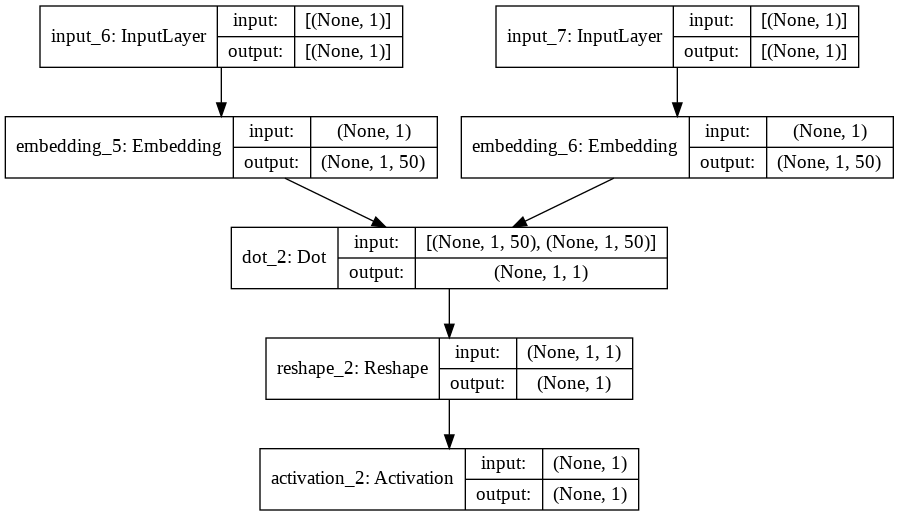

In [58]:
model = word2vec()
model.summary()
plot_model(model, show_shapes=True, show_layer_names=True)

In [59]:
for epoch in range(1, 11):
  loss = 0
  for _, elem in enumerate(cbows):
    first_elem = np.array(list(zip(*elem[0]))[0], dtype='int32')
    second_elem = np.array(list(zip(*elem[0]))[1], dtype='int32')
    labels = np.array(elem[1], dtype='int32')

    X = [first_elem, second_elem]
    Y = labels
    loss += model.train_on_batch(X, Y)

  print('Epoch:', epoch, 'Loss: ', loss)

Epoch: 1 Loss:  1231.7491363883018
Epoch: 2 Loss:  931.232296615839
Epoch: 3 Loss:  832.8403338342905
Epoch: 4 Loss:  786.9516506940126
Epoch: 5 Loss:  760.147240974009
Epoch: 6 Loss:  739.7909237518907
Epoch: 7 Loss:  719.5158765763044
Epoch: 8 Loss:  695.7503014802933
Epoch: 9 Loss:  666.9283323734999
Epoch: 10 Loss:  632.771813955158


In [60]:
import gensim

f = open('cbow.txt', 'w')
f.write('{} {}\n'.format(vocab_size-1, embed_size))
vectors = model.get_weights()[0]
for word, i in tokenizer.word_index.items():
  f.write('{} {}\n'.format(word, ' '.join(map(str, list(vectors[i, :])))))
f.close()

cbow = gensim.models.KeyedVectors.load_word2vec_format('cbow.txt', binary=False)

In [61]:
cbow.most_similar(positive=['soldier'])

[('retalliates', 0.9584009647369385),
 ('indiscriminately', 0.9409950971603394),
 ('pervert', 0.9400926232337952),
 ('traps', 0.9395245909690857),
 ('booby', 0.9370630979537964),
 ('southeastern', 0.9364011883735657),
 ('miracles', 0.9323719143867493),
 ('pillaged', 0.9323552846908569),
 ('hail', 0.9312352538108826),
 ('oooh', 0.9310576915740967)]

In [62]:
cbow.most_similar(positive=['world'])

[('common', 0.9335542321205139),
 ('course', 0.9298855662345886),
 ('seem', 0.928088366985321),
 ('million', 0.9235339164733887),
 ('knows', 0.9227280020713806),
 ('dont', 0.9221134781837463),
 ('story', 0.9216675162315369),
 ('maybe', 0.9161409735679626),
 ('since', 0.9155672788619995),
 ('like', 0.9141899943351746)]